# A machine Learning Model to Predict the CreditWorthiness of Borrowers

In [35]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
# We get our file path
file_path = r"C:\Users\GABRIEL\Desktop\DataSet\Loan Data Train.csv"

In [3]:
# Load the CSV data 
data = pd.read_csv(file_path)
df = pd.DataFrame(data) # Convert the data to dataframe

In [4]:
# Display the first 5 rows of the data
for column in df.columns:
    print(df[column].dtypes)

display(df.head())

int64
object
int64
int64
object
int64
int64
int64
float64
int64
int64
int64
int64
int64
int64


,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750


### We will try to answer the questions
- The goal of this project is to identify individuals who are most likely 
- to repay loans while reducing the risk for financial institutions. 
- You will be judged on your model’s ability to make accurate predictions, 
- approach to feature engineering, and how well you handle the trade-off 
- between precision and recall.

We will drop the columns that are not needed for our analysis, ID and Loan_ID

In [5]:
df.drop(['Loan_ID', 'ID'], axis=1, inplace=True)

In [7]:
# We will explore the data to see the relationship between the features and the target variable
# We will also check for missing values in the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             5898 non-null   int64  
 1   Married            5898 non-null   int64  
 2   Dependents         5898 non-null   object 
 3   Education          5898 non-null   int64  
 4   Self_Employed      5898 non-null   int64  
 5   ApplicantIncome    5898 non-null   int64  
 6   CoapplicantIncome  5898 non-null   float64
 7   LoanAmount         5898 non-null   int64  
 8   Loan_Amount_Term   5898 non-null   int64  
 9   Credit_History     5898 non-null   int64  
 10  Property_Area      5898 non-null   int64  
 11  Loan_Status        5898 non-null   int64  
 12  Total_Income       5898 non-null   int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 599.1+ KB
None


In [15]:
# The Dependents column seems to have a floating point value, we will convert it to an integer
df["Dependents"].unique()

array(['0', '1', '3+', '2'], dtype=object)

Clearly, the Dependents column has a value 3+ which is considered as object. We will convert it to integer

In [17]:
# We will replace the '+' sign in the Dependents column
df["Dependents"].replace(to_replace='3+', value=3, inplace=True)

In [8]:
print(df.describe())

            Gender      Married    Education  Self_Employed  ApplicantIncome  \
count  5898.000000  5898.000000  5898.000000    5898.000000      5898.000000   
mean      0.910817     0.854527     0.120210       0.107664      7782.026958   
std       0.285032     0.352607     0.325235       0.309981      9182.571831   
min       0.000000     0.000000     0.000000       0.000000       150.000000   
25%       1.000000     1.000000     0.000000       0.000000      2342.250000   
50%       1.000000     1.000000     0.000000       0.000000      6989.000000   
75%       1.000000     1.000000     0.000000       0.000000      8375.000000   
max       1.000000     1.000000     1.000000       1.000000     81000.000000   

       CoapplicantIncome   LoanAmount  Loan_Amount_Term  Credit_History  \
count        5898.000000  5898.000000       5898.000000     5898.000000   
mean         1245.954548    97.410478        359.114954        0.920482   
std          2368.012349   103.483478         48.87608

In [9]:
# Check for missing values
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Total_Income         0
dtype: int64

In [19]:
# We will check for the correlation between the features and the target variable
corr = df.corr()['Loan_Status'].sort_values(ascending=False)
corr

Loan_Status          1.000000
Property_Area        0.026883
LoanAmount           0.014613
Loan_Amount_Term     0.008299
Self_Employed        0.005938
Credit_History       0.001133
Gender              -0.004538
Total_Income        -0.004700
CoapplicantIncome   -0.007058
Married             -0.008111
ApplicantIncome     -0.009189
Education           -0.010613
Dependents          -0.021859
Name: Loan_Status, dtype: float64

There is little or no correlation between the target variables and the features suggesting linear model may not be the best fit for our data; we will use polynomial features

In [23]:
# Split the data into features and target variable
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# We predict the target variable using income and loan amount
x1 = df[["ApplicantIncome", "LoanAmount"]]
y1 = df["Loan_Status"]

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

# We will scale the data
scaler1 = StandardScaler()
x1_train_scaled = scaler1.fit_transform(x1_train)
x1_test_scaled = scaler1.transform(x1_test)

# creating a polynomial feature object
poly = PolynomialFeatures(degree=2)
x1_train_poly = poly.fit_transform(x1_train_scaled)
x1_test_poly = poly.transform(x1_test_scaled)

# We will create a logistic regression model
model1 = LogisticRegression()
mod_fit = model1.fit(x1_train_poly, y1_train)
y1_pred = mod_fit.predict(x1_test_poly)

# We will evaluate the model
conf_matrx = confusion_matrix(y1_test, y1_pred)
f1 = f1_score(y1_test, y1_pred)
print("Confusion Matrix: ", conf_matrx)
print("F1 score: ", f1)

Confusion Matrix:  [[   0  294]
 [   0 1476]]
F1 score:  0.9094269870609981


In [30]:
# Create a scaler object and convert the features to a scaled version
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


# Create a polynomial object and convert the features to a polynomial version
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)


# Create a logistic regression object
model = LogisticRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
score = f1_score(y_test, y_pred)
print("Confusion Matrix: ", conf_matrix)
print("F1 score: ", score)

Confusion Matrix:  [[   1  293]
 [   1 1475]]
F1 score:  0.9093711467324291


We further evaluate the model using other metrics

In [31]:
# Evaluate the model using metrics
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision}, Recall: {recall}")

Precision: 0.8342760180995475, Recall: 0.9993224932249323


We use cross validation to get a best estimate of our model's performance

In [34]:
# we will create a cross validation object
cross_val = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='f1')
print("Cross Validation Score: ", cross_val)
print("Cross Validation Mean Score: ", cross_val.mean())
print("Cross Validation Standard Deviation: ", cross_val.std())


Cross Validation Score:  [0.90656064 0.91005291 0.90656064 0.90656064 0.90703851]
Cross Validation Mean Score:  0.9073546662435639
Cross Validation Standard Deviation:  0.001361757980146991


In [36]:
# Adjust the threshold to 0.5 or a lower value to get more predictions for both classes
threshold = 0.5
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]  # Probabilities for the positive class (1)
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Inspect the class distribution of predictions
print(f"Predicted positive class (1) count: {sum(y_pred_adjusted == 1)}")
print(f"Predicted negative class (0) count: {sum(y_pred_adjusted == 0)}")

# print the classification report
print(classification_report(y_test, y_pred_adjusted, zero_division=1))

Predicted positive class (1) count: 1768
Predicted negative class (0) count: 2
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       294
           1       0.83      1.00      0.91      1476

    accuracy                           0.83      1770
   macro avg       0.67      0.50      0.46      1770
weighted avg       0.78      0.83      0.76      1770



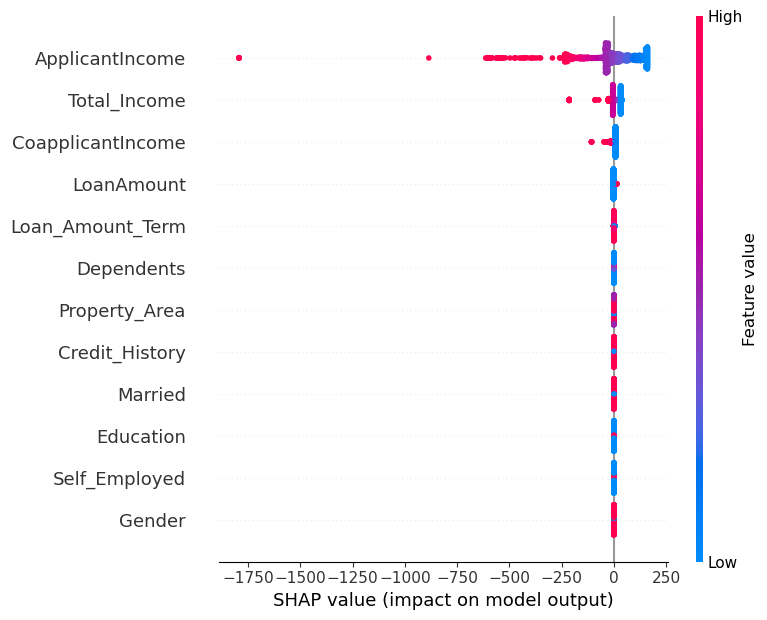

In [38]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

From the above chart, we see that Applicant's income, Total income, coapplicant income and loan amount are the most important features in predicting loan approval (Loan_Status). Further, a good income increases the chance of an applicant's loan approval, however the impact of applicant's income varies for different instances.

### Saving model for reuse
### Still in progress

In [ ]:
# import joblib

# joblib.dump(model, 'creditworthiness_model.pkl')

['creditworthiness_model.pkl']

### Developing a Prediction Frame work like Flask
### Still in progress .....

In [ ]:
# from flask import Flask, request, jsonify
# import joblib

# app = Flask(__name__)
# model = joblib.load('creditworthiness_model.pkl')

# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.json  # Input JSON data
#     prediction = model.predict(data['features'])
#     return jsonify({'prediction': int(prediction[0])})

### Building an interface


### Still in progress ......

In [40]:
# import streamlit as st

# st.title("Creditworthiness Prediction")
# loan_amount = st.number_input("Loan Amount")
# income = st.number_input("Applicant Income")
# # Add other inputs
# if st.button("Predict"):
#     result = model.predict([[income, loan_amount]])
#     st.write(f"Prediction: {'Creditworthy' if result[0] == 1 else 'Not Creditworthy'}")